In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)

In [ ]:
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# import tensorflow as tf
# from tensorflow.keras import layers

## Preprocessing

There are many different ways to pre-process image data, and the method used here is idiosyncratic rather than a best practice. In production code and in industry, you are likely to see many image preprocessing workflows similar to this one, and also many image preprocessing workflows that use keras's inbuilt tools. As keras gains wider adoption, and as keras is developed, I suspect more workflows will use keras's inbuilt tools, and fewer will use bespoke processes like the one below.

In particular you should know about keras's [`image_dataset_from_directory`](https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function) function, which is a convenient way to read in a directory of image data. Some of these tools allow for data augmentation as the data are imported and processed, which can be especially valuable when we have smaller datasets.

### Importing the data

The code below will do the following:

- Create a list to store array representations of images from a given class
- Convert the array to a normalized representation
- Store the normalized array
- Print an error message for files that could not be converted
- Convert the lists to a numpy array representation for compatibility with keras

In [2]:
data_path = '../mask_data/'

In [3]:
# create list
unmasked_arrays = []
# define filepath for unmasked class
folder_list = ['09000/', '10000/', '11000/']

# convert each image to normalized array and store
for folder in folder_list:
  unmasked_path = data_path + folder

  for file in os.listdir(unmasked_path):
      #print(file)
      #print(dog_path+file)
      try:
          # target_size automatically resizes each img on import
          face = load_img(unmasked_path + file, target_size=(256, 256))
          face_arr = img_to_array(face) / 255
          unmasked_arrays.append(face_arr)
      except:
          print(f'Error for file: {file}')

print(f'{len(unmasked_arrays)} pictures converted.')  
num_unmasked = len(unmasked_arrays)  

Error for file: .ipynb_checkpoints
3000 pictures converted.


In [5]:
# create list
inc_masked_arrays = []
# define filepath for incorrectly masked class
folder_list = ['13000/', '14000/', '15000/']

for folder in folder_list:
  inc_masked_path = data_path + folder

  # convert each image to normalized array and store
  for file in os.listdir(inc_masked_path):
      #print(file)
      #print(dog_path+file)
      try:
          # target_size automatically resizes each img on import
          face = load_img(inc_masked_path + file, target_size=(256, 256))
          face_arr = img_to_array(face) / 255
          inc_masked_arrays.append(face_arr)
      except:
          print(f'Error for file: {file}')

print(f'{len(inc_masked_arrays)} pictures converted.')
num_inc_unmasked = len(inc_masked_arrays)      

Error for file: .ipynb_checkpoints
2877 pictures converted.


In [6]:
# create list
masked_arrays = []
# define filepath for correctly masked class
folder_list = ['04000/', '05000/', '06000/']

for folder in folder_list:
  masked_path = data_path + folder

  # convert each image to normalized array and store
  for file in os.listdir(masked_path):
      #print(file)
      #print(dog_path+file)
      try:
          # target_size automatically resizes each img on import
          face = load_img(masked_path + file, target_size=(256, 256))
          face_arr = img_to_array(face) / 255
          masked_arrays.append(face_arr)
      except:
          print(f'Error for file: {file}')

print(f'{len(masked_arrays)} pictures converted.')    
num_cor_masked = len(masked_arrays)  

Error for file: .ipynb_checkpoints
Error for file: .ipynb_checkpoints
2907 pictures converted.


In [7]:
# X should contain both cats and dogs
X = unmasked_arrays + masked_arrays + inc_masked_arrays
# convert to array and check shape
X = np.array(X)
print(f'X shape: {X.shape}')

# 0 for unmasked, 1 for correct masked, 2 for incorrectly masked
y = [0] * num_unmasked + [1] * num_cor_masked + [2] * num_inc_unmasked
y = to_categorical(y)
# convert to array and check shape
y = np.array(y)
print(f'y shape: {y.shape}')

X shape: (8784, 256, 256, 3)
y shape: (8784, 3)


### Train-test splitting

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [9]:
X_train = np.array(X_train)#.reshape(1499, 256, 256, 3)

In [10]:
X_test = np.array(X_test)#.reshape(500, 256, 256, 3)

In [11]:
X_train[0].shape

(256, 256, 3)

In [12]:
y_train.shape

(6588, 3)

## Convolutional Neural Networks

CNNs do some complicated math up front to represent images more effectively and in a way that generalizes, allowing us to learn far fewer parameters in later layers.

A CNN will generally consist of three types of layers:

- Convolutional Layer
- Pooling Layer
- Densely Connected Layer

<img src="images/cnn.jpeg" alt="drawing" width="600"/>

[Image source.](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

### Convolution Layers

The convolution layer is where we pass a filter over an image and do some calculation at each step. Specifically, we take pixels that are close to one another, then summarize them with one number. The goal of the convolution layer is to identify important features in our images, like edges.

<img src="images/convolution.gif" alt="drawing" width="550"/>

[Image source.](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)

Our hyperparameters here are:
- the number of filters to use
- the dimensions of the filter

**How many filters should we use?** Well, this is a hyperparameter. There's not one great answer, but the idea is that each filter can detect one type of feature in an image (like vertical edges). This may depend on the complexity of your images (simpler images require fewer filters) and usually requires trial and error to identify an adequate value of `filters`. [Source](https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional)

### Pooling Layer

Remember that CNNs learn far fewer parameters than a regular feed-forward neural network. Most of the "parameter reduction" comes from the pooling layer.

<img src="images/maxpool.png" alt="drawing" width="400"/>

[Image source.](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)

In Max Pooling, we pass a filter over an image. At each step, we take the maximum value and record it as part of the output.
- Average Pooling exists, but is far less frequently used. [Andrew Ng](https://www.deeplearning.ai/deep-learning-specialization/) recommends using Max Pooling.
- When pooling, we generally partition the result from the previous layer. That is, the filter does not usually overlap like it does in the convolutional layer.

Our hyperparameters here are the **dimensions of the filter we use when pooling**. This is given by `pool_size = (2, 2)` in our example.

##### Why use max pooling?
1. Reduces the data dimensionality.
2. Protects against overfitting by creating a more abstract representation.
3. Provides some invariance by ignoring insignificant local changes in the image.

### Densely-Connected Layer
The densely-connected layer is the exact same as in a normal feed-forward neural network, so we won't spend any time talking about that, **except: remember to pass a `Flatten()` layer before a `Dense()` layer!**

In [ ]:
##### TODO: add early stopping 

input_shape = (256,256,3)
model = Sequential()

# conv, pool 
# 64 filters, (3,3) will need to tune these hyperparameters later
# two rounds of feature selection! 
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))

# # conv, pool
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# flatten/dense, dense layer needs the flat format because it can't handle a matrix
model.add(Flatten())
model.add(Dense(16, activation='relu'))

# dense/output
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
             loss='categorical_crossentropy', 
             metrics=['acc'])

results = model.fit(X_train, y_train,
         validation_data=(X_test, y_test),
         epochs=10,
         batch_size=64,
         verbose=2)

In [29]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                984080    
_________________________________________________________________
dense_17 (Dense)             (None, 3)                

In [30]:
preds = model.predict(X_test)

In [31]:
preds[2]

array([9.9999976e-01, 1.0971730e-19, 2.8489143e-07], dtype=float32)

In [32]:
model.save('face_model.h5')

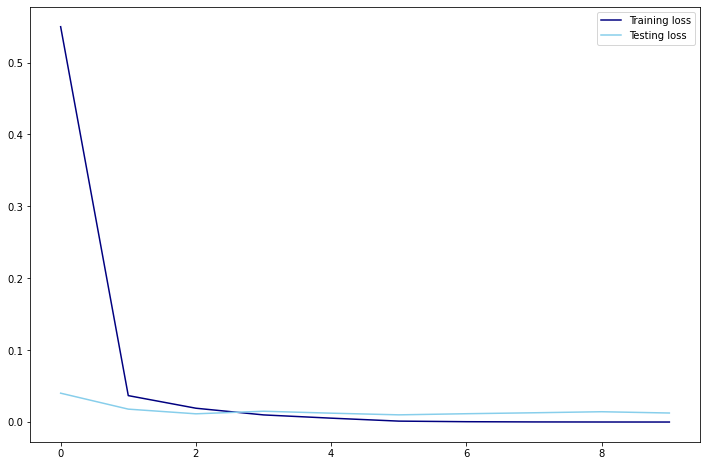

In [33]:
# Visualize the loss
train_loss = results.history['loss']
test_loss = results.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

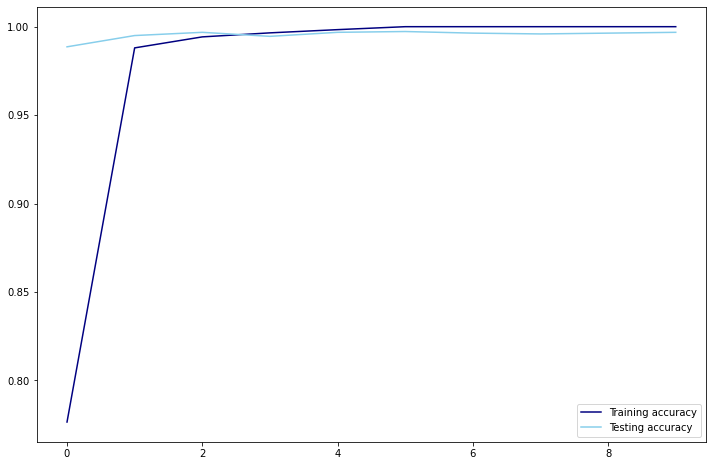

In [34]:
# Visualize the accuracy
train_acc = results.history['acc']
test_acc = results.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training accuracy', color='navy')
plt.plot(test_acc, label='Testing accuracy', color='skyblue')
plt.legend();

In [40]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [42]:
len(preds)

2196

In [43]:
# loop over the detected face locations and their corresponding locations
predictions = []

for pred in preds:
    Unmasked, Masked, Incorrectly_Masked = pred
    
    if max([Unmasked, Masked, Incorrectly_Masked]) == Masked:
        predictions.append(1)
        color = (0, 255, 0)
    elif max([Unmasked, Masked, Incorrectly_Masked]) == Unmasked:
        predictions.append(0)
        
    else:
        predictions.append(2)
        
        

In [45]:
predictions[:10]

[0, 2, 0, 0, 2, 2, 0, 0, 0, 0]

In [57]:
predictions.count(0)/len(predictions)

0.3424408014571949

In [58]:
predictions.count(1)/len(predictions)

0.3319672131147541

In [59]:
predictions.count(2)/len(predictions)

0.325591985428051

-----

## Additional resources

- [Convnets on small datasets](https://rstudio-pubs-static.s3.amazonaws.com/343094_6e28962e50814b3ab33d4d816a79e66e.html)
- [Keras: image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)
- [Keras: building powerful models on small datasets](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
- [Keras: transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning)
- [Chollet: visualizing what convnets learn](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb)
- [Jordan: intro to convnets](https://www.jeremyjordan.me/convolutional-neural-networks/)